In [1]:
import numpy as np
from numpy import pi
from scipy.constants import epsilon_0, mu_0
from scipy.special import jv, jvp, h2vp
from scipy.special import hankel2 as h2v
from matplotlib import pyplot as plt
import sys
sys.path.insert(1, '../../../eispy2d/library/')
import configuration as cfg
import inputdata as ipt
import experiment as exp
import mom_cg_fft as mom

# How to implement the analytic solution for shifted and rotated cases

The analytic solution for the scattering of a circular cylinder due to an incident plane wave is known and determined by (Harrington 1961):

$$ E_z^s = E_0 \sum_{n=-\infty}^\infty j^{-n} a_n H_n^{(2)}(k\rho) e^{jn\phi},~ \rho > a \\
   E_z = E_0 \sum_{n=-\infty}^\infty j^{-n}\left[ J_n(k\rho) + a_n H_n^{(2)}(k\rho) \right] e^{jn\phi},~ \rho > a \\
   E_z = E_0 \sum_{n=-\infty}^\infty j^{-n} c_n J_n(k_d\rho) e^{jn\phi},~ \rho \le a $$

where:

$$ a_n = \frac{-J_n(ka)}{H_n^{(2)}(ka)} \left[ \frac{\epsilon_dJ_n^\prime(k_da)/\epsilon k_daJ_n(k_da) - J_n^\prime(ka)/kaJ_n(ka)} {\epsilon_dJ_n^\prime(k_da)/\epsilon k_daJ_n(k_da) - H_n^{(2)\prime}(ka)/kaH_n^{(2)}(ka)}  \right] \\
c_n = \frac{1}{J_n(k_da)} \left[ J_n(ka) + a_n H_n^{(2)}(ka) \right] $$

This is the solution for a centered circle with the incident field coming from the left to the right. This notebook discusses the implementation of the equations when the circle and the incidence angle are shifted.

First of all, let us define the values of the parameters:

In [2]:
E0 = 1. # Magnitude of incident field [V/m]
lambdab = 1.0 # Wavelegnth of incident wave [1/m]
a = 0.25*lambdab # Radius of the circle [m]
e = epsilon_0 # Background permittivity [F/m]
ed = 6*epsilon_0 # Object permittivity [F/m]
NM = 16 # Number of measurements of the scattered field
Ro = 5*a # Radius of observation of the scattered field [m]
resolution = (60, 60) # Number of pixels for total field images
Lx, Ly = 4*a, 4*a # Size of the image
n = np.arange(-100, 101, dtype=float) # Sum indexes

Then, let us define the constants of our problem:

In [3]:
k = 2*pi/lambdab # Background wavenumber [m]
omega = k/np.sqrt(e*mu_0) # Angular frequency [rad]
kd = omega*np.sqrt(ed*mu_0) # Object wavenumber [m]
dx, dy = Lx/resolution[0], Ly/resolution[1] # image discretization [m]

# Sum coefficients
an = (-jv(n, k*a)/h2v(n, k*a)*(ed*jvp(n, kd*a)/(e*kd*a*jv(n, kd*a))
                               - jvp(n, k*a)/(k*a*jv(n, k*a)))
      / (ed*jvp(n, kd*a)/(e*kd*a*jv(n, kd*a))- h2vp(n, k*a)/(k*a*h2v(n, k*a))))
cn = 1/jv(n, kd*a)*(jv(n, k*a) + an*h2v(n, k*a))

Now, we will define the displacement of the circle concerning the center, the number of incidence angles, and the incidence angles ($\theta$):

In [4]:
deltax, deltay = -.5*Lx/2, .5*Ly/2
NS = 8 # Number of incidence angles
theta = np.linspace(0, 2*pi, NS, endpoint=False) # Incidence angles [rad]

Two useful functions for this notebook will be the rotation of the axes and the transformation of the cartesian coordinates into polar ones:

In [5]:
def rotate_axes(x, y, angle):
    """Rotate axes."""
    xr = np.cos(angle)*x + np.sin(angle)*y
    yr = -np.sin(angle)*x + np.cos(angle)*y
    return xr, yr

def cart2pol(x, y):
    """Transform cartesian coordinates into polar ones."""
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    phi[phi<0] = 2*pi + phi[phi<0]
    return rho, phi

Based on these definitions, the problem may be visualized as follows:

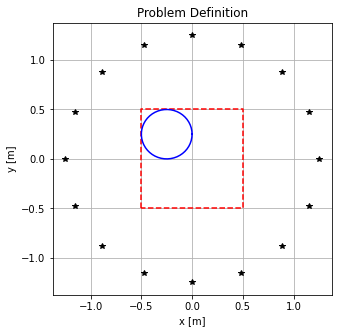

In [6]:
# Measurements coordinates
xm = Ro*np.cos(np.linspace(0, 2*pi, NM, endpoint=False))
ym = Ro*np.sin(np.linspace(0, 2*pi, NM, endpoint=False))

# Figure creation
fig, axis = plt.subplots(figsize=(5, 5))
axis.plot([-Lx/2, -Lx/2, Lx/2, Lx/2, -Lx/2], [-Ly/2, Ly/2, Ly/2, -Ly/2, -Ly/2], '--r')
axis.plot(xm, ym, '*k')
axis.plot(a*np.cos(np.linspace(0, 2*pi))+deltax,
          a*np.sin(np.linspace(0, 2*pi))+deltay, 'b')
axis.grid(True)
axis.set_xlabel('x [m]')
axis.set_ylabel('y [m]')
axis.set_title('Problem Definition')
plt.show()

## Solution

When the circle is shifted from the center, the equivalent solution is obtained by simply oppositely shifting the measurement points. Therefore, if we are shifting the circle to ($\delta_x$, $\delta_y$), then the equivalent measurement point is ($x_m-\delta_x$, $y_m-\delta_y$).

In the case of a shift at the incidence angle, the equivalent solution is obtained by rotating the axis after the displacement of position, i.e., the equivalent points is ($[x_m-\delta_x]\cos\theta$, $[y_m-\delta_y]\sin\theta$). However, an important thing must be corrected: the incident wave phase. We must add a phase correction in order to obtain the equivalent real and imaginary components. This is accomplished by multiplying the field by:

$$ e^{-jk(\delta_x\cos\theta + \delta_y\sin\theta)} $$

Let us compute the scattered field at the pre-defined measurement points:

In [7]:
# Scattered field array
Es = np.zeros((NM, NS), dtype=complex)
for s in range(NS):

    # Shift, rotate and transform coordinates
    xr, yr = rotate_axes(xm-deltax, ym-deltay, theta[s])
    rho, phi = cart2pol(xr, yr)

    for i in range(n.size):
        Es[:, s] += (E0*1j**(-n[i])*an[i]*h2v(n[i], k*rho)
                     * np.exp(1j*n[i]*phi)
                     * np.exp(-1j*k*(deltax*np.cos(theta[s])
                                     + deltay*np.sin(theta[s]))))

Let us compute the total field at the image domain:

In [8]:
# Cartersian coordinates
x, y = np.meshgrid(np.arange(-Lx/2+dx/2, Lx/2, dx),
                  np.arange(-Ly/2+dy/2, Ly/2, dy))

# Total field array
E = np.zeros((x.shape[0], x.shape[1], NS), dtype=complex)

for s in range(NS):

    # Shift, rotate, and transform
    xr, yr = rotate_axes(x-deltax, y-deltay, theta[s])
    rho, phi = cart2pol(xr, yr)

    for i in range(n.size):

        # Outside circle
        E[rho > a, s] += (E0*1j**(-n[i])
                          * (jv(n[i], k*rho[rho > a]) + an[i]*h2v(n[i], k*rho[rho > a]))
                          * np.exp(1j*n[i]*phi[rho > a])
                          * np.exp(-1j*k*(deltax*np.cos(theta[s]) + deltay*np.sin(theta[s]))))

        # Inside circle
        E[rho <= a, s] += (E0*1j**(-n[i])
                           * cn[i]*jv(n[i], kd*rho[rho <= a])
                           * np.exp(1j*n[i]*phi[rho <= a])
                           * np.exp(-1j*k*(deltax*np.cos(theta[s]) + deltay*np.sin(theta[s]))))

Now, let us run the Method of Moments in order to have something to compare:

In [9]:
# Configuration object
config = cfg.Configuration(name='basic',
                          number_measurements=NM,
                          number_sources=NS,
                          observation_radius=Ro,
                          wavelength=lambdab,
                          image_size=[Lx, Ly],
                          wavelength_unit=False,
                          perfect_dielectric=True)

# Instance object
instance = ipt.InputData(name='shifted',
                        configuration_filename=config.name,
                        relative_permittivity_map=exp.draw_circle(a,
                                                                  resolution=resolution,
                                                                  axis_length_x=Lx,
                                                                  axis_length_y=Ly,
                                                                  object_relative_permittivity=ed/epsilon_0,
                                                                  center=[deltay, deltax])[0])

# Run solver
solver = mom.MoM_CG_FFT(config, tolerance=1e-6, maximum_iterations=5000)
_ = solver.solve(instance)

Now, let us pair each incidence to compare solutions:

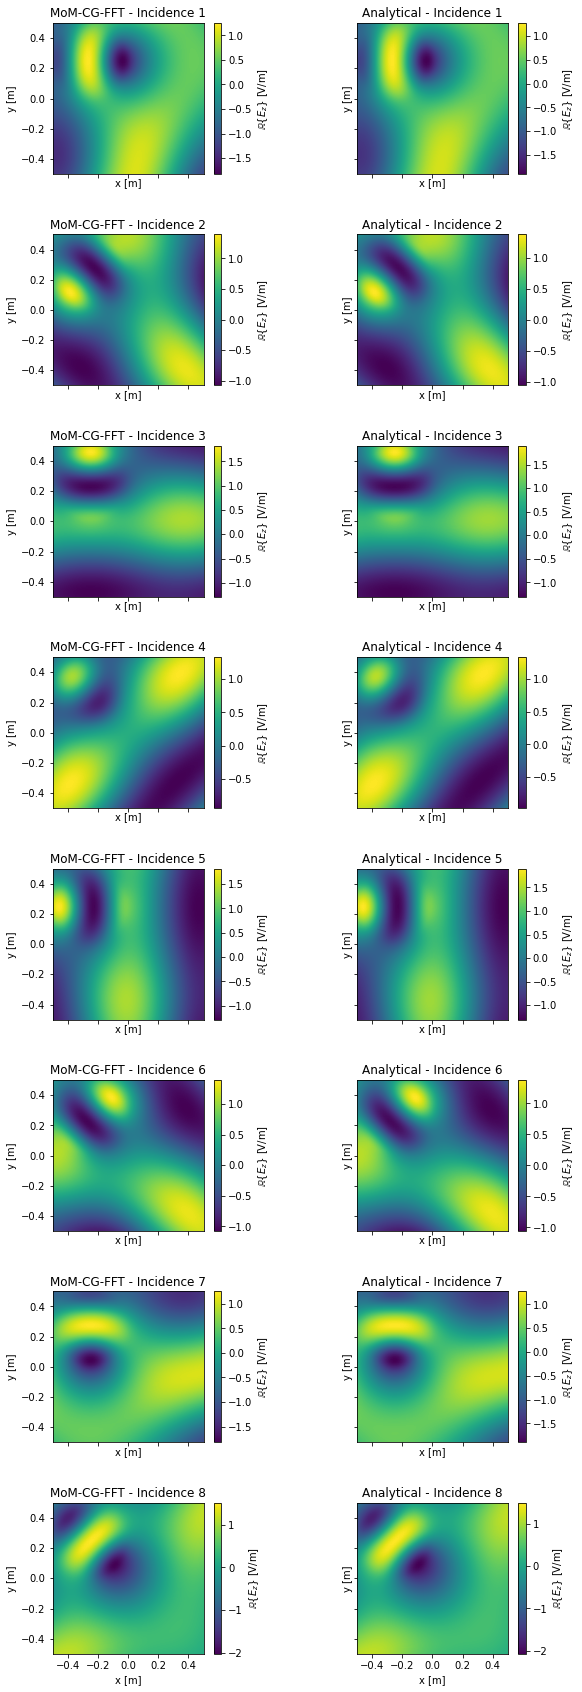

In [10]:
fig, axis = plt.subplots(ncols=2, nrows=NS, figsize=(10, 30), sharex=True, sharey=True)
fig.subplots_adjust(wspace=.2, hspace=.4)
axis = axis.flatten()
colorbar_label = r'$\mathbb{R}\{E_z\}$ [V/m]'

ifig = 0
for s in range(NS):

    img = axis[ifig].imshow(np.real(instance.et[:, s].reshape(x.shape)),
                            origin='lower',
                            extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                            interpolation='bilinear')

    clb = fig.colorbar(img, ax=axis[ifig], fraction=0.046, pad=0.04)
    clb.set_label(colorbar_label)
    axis[ifig].set_title('MoM-CG-FFT - Incidence %d' %(s+1))
    axis[ifig].set_xlabel('x [m]')
    axis[ifig].set_ylabel('y [m]')

    img = axis[ifig+1].imshow(np.real(E[:, :, s].reshape(x.shape)),
                              origin='lower',
                              extent=[-Lx/2, Lx/2, -Ly/2, Ly/2],
                              interpolation='bilinear')

    clb = fig.colorbar(img, ax=axis[ifig+1], fraction=0.046, pad=0.04)
    clb.set_label(colorbar_label)
    axis[ifig+1].set_title('Analytical - Incidence %d' %(s+1))
    axis[ifig+1].set_xlabel('x [m]')
    axis[ifig+1].set_ylabel('y [m]')

    ifig += 2

plt.show()

Even though there is a slight difference in amplitude, both solutions seem to agree with each other. This difference might be due to approximation in the Method of Moments.

## References

Harrington, Roger F. *Time-harmonic electromagnetic fields*. McGraw-Hill, 1961.